# PhyloP overlap hotspots with conserved regions and compare to randomized set (in CDS) using a Mann Whitney U test

In [1]:
import numpy as np
import pandas as pd
import pyBigWig
import pysam
import os
import glob
import pybedtools
from scipy.stats import mannwhitneyu
from collections import defaultdict
from tqdm import trange, tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
import random
from matplotlib_venn import venn2
pybedtools.set_tempdir('/scratch/bay001/pybedtools_tmp/')

In [2]:
input_dir = 'inputs/'
output_dir = 'outputs/'
tmp_dir = 'hotspot_regions'
gtf_file = 'Mus_musculus.GRCm39.112.chr.gtf'

# Find a way to extract values from bigwig phastcon/phyloP files

In [3]:
seed = 3  # random seed for bedtools shuffle

In [4]:
# downloaded here https://hgdownload.soe.ucsc.edu/goldenPath/mm39/phastCons35way/
# https://hgdownload.soe.ucsc.edu/goldenPath/mm39/phyloP35way/mm39.phyloP35way.bw
phastcons = os.path.join(input_dir, 'mm39.phastCons35way.bw')
phylop = os.path.join(input_dir, 'mm39.phyloP35way.bw')

In [5]:
# copied from https://github.com/YeoLab/rbp-maps/blob/master/maps/density/ReadDensity.py
class Density:
    def values(self, chrom, start, end, strand):
        return 0
        
class Phastcon(Density):

    def __init__(self, phastcon, name=None):
        try:
            self.phastcon = pyBigWig.open(phastcon)
            self.name = name if name is not None else os.path.basename(phastcon)
        except Exception as e:
            print("couldn't open the bigwig files!")
            print(e)

    def values(self, chrom, start, end, strand):
        """

        Parameters
        ----------
        chrom : basestring
            (eg. chr1)
        start : int
            0-based start (first position in chromosome is 0)
        end : int
            1-based end (last position is not included)
        strand : str
            either '+' or '-'

        Returns
        -------
        densites : list
            values corresponding to density over specified positions.
        """

        try:
            if strand == "+":
                return self.phastcon.values(chrom, start, end)
            elif strand == "-":
                return list(reversed(self.phastcon.values(chrom, start, end)))
            else:
                print("Strand neither + or -")
                return 1
        except RuntimeError:
            # usually occurs when no chromosome exists in the bigwig file
            return [np.NaN] * abs(start - end)

    def avg_value(self, chrom, start, end, strand):
        values = [x for x in self.values(chrom, start, end, strand) if str(x) != 'nan']
        return 0 if len(values) == 0 else sum(values) / len(values) # all nans or no data in this track for this region
        
pc = Phastcon(phastcons)
ph = Phastcon(phylop)

In [6]:
pc.values('chr1', 3050025, 3050032, '+'), ph.values('chr1', 3050025, 3050032, '+')  # test this function to ensure the values match what we see on UCSC.

([0.503000020980835,
  0.5149999856948853,
  0.5149999856948853,
  0.5080000162124634,
  0.4869999885559082,
  0.4410000145435333,
  0.3479999899864197],
 [0.8510000109672546,
  0.8510000109672546,
  0.6840000152587891,
  0.7549999952316284,
  0.8510000109672546,
  0.8510000109672546,
  0.8510000109672546])

In [7]:
pc.avg_value('chr1', 3050025, 3050032, '+'), ph.avg_value('chr1', 3050025, 3050032, '+')  # test this function to ensure the values match what we see on UCSC.

(0.47385714309556143, 0.8134285807609558)

## Read in and filter for 'significant' events
- use abs(0.1) as a threshold for positive or negative impact

In [8]:
# input_file = os.path.join(input_dir, '40_nucleotide_deletion_differences_allseqs_names_low_threshold.coords.tsv')  # coords are 0 based
input_file = os.path.join(input_dir, 'deletion_effects_threshold_1_30_nucleotides.coords.tsv')  # coords are 0 based
impact = 'negative'  # positive, negative, both

df = pd.read_csv(input_file, sep='\t')
print(f"Before filtering impact score: {df.shape[0]}")

if impact == 'positive':
    df = df[df['difference'] >= 0.1]
elif impact == 'negative':
    df = df[df['difference'] <= -0.1]
elif impact == 'both':
    df = df[(df['difference'] >= 0.1) | (df['difference'] <= -0.1)]
print(f"After filtering impact score: {df.shape[0]}")

def get_chrom(row):
    try:
        return row['coords'].split(':')[0].replace('chrMT', 'chrM')
    except AttributeError:
        pass  # (eg. ENSMUST00000002344) doesn't exist in geneset anymore.

df['chrom'] = df.apply(get_chrom, axis=1)
df['id'] = df['transcript_id']  # this is a useful column even if it's a little redundant.
df.set_index('transcript_id', inplace=True)
df.head()


Before filtering impact score: 5722830
After filtering impact score: 16113


,deletion_index_start,deletion_index_end,difference,synapse_probability,external_gene_name,coords,chrom,id
transcript_id,,,,,,,,
ENSMUST00000000033,105,135,-0.292969,0.550781,Igf2-201,"chr7:142209527-142209553:-,chr7:142211124-1422...",chr7,ENSMUST00000000033
ENSMUST00000000033,120,150,-0.417969,0.425781,Igf2-201,chr7:142209512-142209542:-,chr7,ENSMUST00000000033
ENSMUST00000000033,135,165,-0.731934,0.111816,Igf2-201,chr7:142209497-142209527:-,chr7,ENSMUST00000000033
ENSMUST00000000033,150,180,-0.725098,0.118652,Igf2-201,chr7:142209482-142209512:-,chr7,ENSMUST00000000033
ENSMUST00000000033,165,195,-0.451172,0.392578,Igf2-201,chr7:142209467-142209497:-,chr7,ENSMUST00000000033


### Intersect with synapse-relted transcripts (or maybe not, TBD)...

In [9]:
synapse_transcripts = set(pd.read_csv(os.path.join(input_dir, 'synapse_trans_threshold_1.csv'), index_col=0)['synapse_transcript_id'])
print("Number of synapse transcripts", len(synapse_transcripts))

Number of synapse transcripts 4579


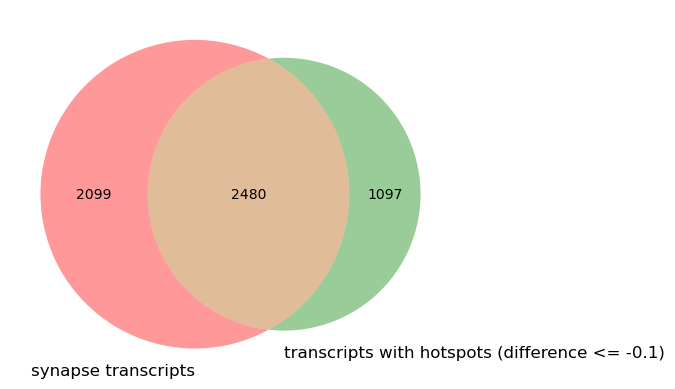

In [10]:
venn2([synapse_transcripts, set(df.index)], ['synapse transcripts', 'transcripts with hotspots (difference <= -0.1)'])

In [11]:
# df = df[df.index.isin(synapse_transcripts)]  # uncomment if we want to filter these.
df

,deletion_index_start,deletion_index_end,difference,synapse_probability,external_gene_name,coords,chrom,id
transcript_id,,,,,,,,
ENSMUST00000000033,105,135,-0.292969,0.550781,Igf2-201,"chr7:142209527-142209553:-,chr7:142211124-1422...",chr7,ENSMUST00000000033
ENSMUST00000000033,120,150,-0.417969,0.425781,Igf2-201,chr7:142209512-142209542:-,chr7,ENSMUST00000000033
ENSMUST00000000033,135,165,-0.731934,0.111816,Igf2-201,chr7:142209497-142209527:-,chr7,ENSMUST00000000033
ENSMUST00000000033,150,180,-0.725098,0.118652,Igf2-201,chr7:142209482-142209512:-,chr7,ENSMUST00000000033
ENSMUST00000000033,165,195,-0.451172,0.392578,Igf2-201,chr7:142209467-142209497:-,chr7,ENSMUST00000000033
...,...,...,...,...,...,...,...,...
ENSMUST00000239509,300,330,-0.187500,0.746094,Tusc3-202,chr8:39473298-39473328:+,chr8,ENSMUST00000239509
ENSMUST00000239510,135,165,-0.283203,0.322266,Tusc3-203,chr8:39473196-39473226:+,chr8,ENSMUST00000239510
ENSMUST00000239510,150,180,-0.281250,0.324219,Tusc3-203,chr8:39473211-39473241:+,chr8,ENSMUST00000239510


## number of hotspots in each transcript

In [12]:
pd.DataFrame(df['id'].value_counts()).sort_values(by='count', ascending=False)

,count
id,
ENSMUST00000151136,53
ENSMUST00000097732,44
ENSMUST00000110969,34
ENSMUST00000074622,31
ENSMUST00000180035,30
...,...
ENSMUST00000114548,1
ENSMUST00000225476,1
ENSMUST00000079594,1


## Number of exons that contain a hotspot (may overlap, need to merge)

In [13]:
df['num_exons'] = df['coords'].apply(lambda x: len(x.split(',')) if type(x) != float else 0)
print(f"total exons: {pd.DataFrame(df.groupby('id')['num_exons'].sum()).sum()}")
pd.DataFrame(df.groupby('id')['num_exons'].sum()).sort_values(by='num_exons', ascending=False)

total exons: num_exons    17776
dtype: int64


,num_exons
id,
ENSMUST00000151136,54
ENSMUST00000097732,46
ENSMUST00000180035,38
ENSMUST00000049470,34
ENSMUST00000110969,34
...,...
ENSMUST00000167946,0
ENSMUST00000044638,0
ENSMUST00000046223,0


## Next merge coordinates
- Here we group by transcript ID, and for each transcript, add the real coordinates of a given hotspot.
- We'll merge these coordinates later in case they overlap.

```
For example, consider the following transcript with two exons separated by one intron:

[AACTGA]-------------[AGCCC]

With overlapping hotspots:

[AACTG]
  [CTGAAG]
     [AAGCCC]

This should produce coordinates corresponding to the sequence:

[AACTGAAGCCC]

Per a previous discussion, we want to keep bookended hotspots separate ("x" signifies hotspot that does not meet threshold). For example, if we "remove" the middle hotspot:
[     ]
   [  x  ]
      [     ]

Should produce coordinates corresponding to sequences:

[AACTG], [AAGCCC]

We also want to consider exon boundaries ("|" signifies an exon/intron boundary). Creating a BED file of these regions may result in hotspots being split by exons:

[AACTG]|
  [CTGA|AG]
     [A|AGCCC]

Exon boundaries will split hotspot into their respective exons:

[AACTGA], [AGCCC]

And if the middle hotspot does not meet the threshold:

[AACTG]|
  [  x   ]
     [A|AGCCC]

We may see these sequences:

[AACTG], [A], [AGCCC]
```

### create bedtools from hotspots

```
hotspots_per_transcript = dict where {transcript: BedTool(exon intervals for all hotspots in transcript)}
```

In [14]:
hotspots_per_transcript = defaultdict(list)
wrong_annotations = set()  # annotations that were correct in whatever version the model was trained on, but not identical to annotations in this latest version (112 Ensembl)
score = '0'
progress = trange(len(set(df.index)), position=0, leave=False)
for transcript in set(df.index):
    transcript_regions = df.loc[[transcript]]
    intervals = []
    for index, row in transcript_regions.iterrows():  # handles each hotspot region within a transcript
        try:
            for coords in row['coords'].split(','):  # handles instances where one hotspot spans multiple exons
                chrom, pos, strand = coords.split(':')
                start, end = pos.split('-')
                intervals.append(pybedtools.create_interval_from_list([chrom.replace('chrMT', 'chrM'), start, end, transcript, score, strand]))
        except AttributeError:  # when relative coords exceed actual coords, it's represented as nan in the file (or when transcript doesn't exist in annotation)
            wrong_annotations.add(transcript)
    if len(intervals) > 0:  # if a transcript has at least one interval, merge overlapping intervals and separate bookended intervals (d=-1)
        bedtool = pybedtools.BedTool(intervals).sort()
        bedtool = bedtool.merge(s=True, c='4,5,6', o='distinct,distinct,distinct', d=-1)
        hotspots_per_transcript[transcript] = bedtool
    progress.update(1)

print(f"Found {len(wrong_annotations)} (out of {len(set(df.index))}) transcripts with mismatched annotations between current version I'm using, and the annotations the model was trained on")
print(wrong_annotations)

100%|██████████| 3577/3577 [03:05<00:00, 19.70it/s]

Found 16 (out of 3577) transcripts with mismatched annotations between current version I'm using, and the annotations the model was trained on
{'ENSMUST00000038628', 'ENSMUST00000170248', 'ENSMUST00000004316', 'ENSMUST00000166580', 'ENSMUST00000098566', 'ENSMUST00000093855', 'ENSMUST00000163716', 'ENSMUST00000167078', 'ENSMUST00000050686', 'ENSMUST00000044638', 'ENSMUST00000167946', 'ENSMUST00000170156', 'ENSMUST00000002344', 'ENSMUST00000086400', 'ENSMUST00000086674', 'ENSMUST00000046223'}


## Number of hotspots per transcript (after merging overlapping, and discarding "wrongly annotated" ones)

In [15]:
num_hotspots = {}
for transcript in hotspots_per_transcript.keys():
    num_hotspots[transcript] = len(hotspots_per_transcript[transcript])
print(f"Total hotspots: {pd.DataFrame(num_hotspots, index=['num_hotspots']).T['num_hotspots'].sum()}")
pd.DataFrame(num_hotspots, index=['num_hotspots']).T.sort_values(by='num_hotspots', ascending=False)

Total hotspots: 6899


,num_hotspots
ENSMUST00000151136,16
ENSMUST00000180035,15
ENSMUST00000151280,12
ENSMUST00000021930,12
ENSMUST00000166814,11
...,...
ENSMUST00000050772,1
ENSMUST00000113822,1
ENSMUST00000002837,1
ENSMUST00000076968,1


Text(0.5, 0.98, 'Number of nonoverlapping hotspots per transcript')

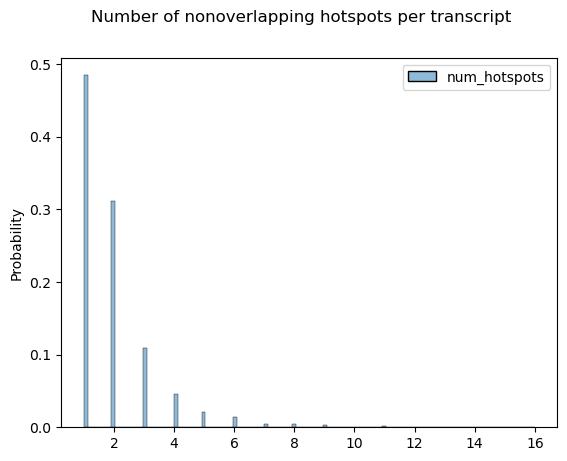

In [16]:
fig, ax = plt.subplots()
sns.histplot(pd.DataFrame(num_hotspots, index=['num_hotspots']).T, ax=ax, stat="probability")
fig.suptitle("Number of nonoverlapping hotspots per transcript")

# Then obtain phastcons or phyloP values for each hotspot (all regions):

PhastCons (which has been used in previous Conservation tracks) is a hidden Markov model-based method that estimates the probability that each nucleotide belongs to a conserved element, based on the multiple alignment. It considers not just each individual alignment column, but also its flanking columns. By contrast, phyloP separately measures conservation at individual columns, ignoring the effects of their neighbors. As a consequence, the phyloP plots have a less smooth appearance than the phastCons plots, with more "texture" at individual sites. The two methods have different strengths and weaknesses. PhastCons is sensitive to "runs" of conserved sites, and is therefore effective for picking out conserved elements. PhyloP, on the other hand, is more appropriate for evaluating signatures of selection at particular nucleotides or classes of nucleotides (e.g., third codon positions, or first positions of miRNA target sites).

Another important difference is that phyloP can measure acceleration (faster evolution than expected under neutral drift) as well as conservation (slower than expected evolution). In the phyloP plots, sites predicted to be conserved are assigned positive scores (and shown in blue), while sites predicted to be fast-evolving are assigned negative scores (and shown in red). The absolute values of the scores represent -log p-values under a null hypothesis of neutral evolution. The phastCons scores, by contrast, represent probabilities of negative selection and range between 0 and 1.

### Define hotspot_phastcons and hotspot_phylop as dictionaries that will store phastcon regions for hotspots for each region (keys = region)

In [17]:
hotspot_phastcons = defaultdict(list)
hotspot_phylop = defaultdict(list)

In [18]:
# This is ALL phastcons for all regions (we will do a per-region analysis below). We may end up not using this in the final analysis, but we'll see.

hotspots = []
progress = trange(len(hotspots_per_transcript.keys()), position=0, leave=False)
for transcript, bedtool in hotspots_per_transcript.items():
    for i in bedtool:
        try:
            hotspot_phastcons['exons'].append(pc.avg_value(i.chrom, i.start, i.end, i.strand))
            hotspot_phylop['exons'].append(ph.avg_value(i.chrom, i.start, i.end, i.strand))
            hotspots.append(i)
        except Exception as e:
            print(transcript, i.chrom, i.start, i.end, i.strand)
            print(pc.values(i.chrom, i.start, i.end, i.strand))
            raise
    progress.update(1)

hotspots = pybedtools.BedTool(hotspots)  # re-format hotspots_per_transcript to combine all intervals from all transcripts (hotspots_per_transcript is one bedtool per transcript)

100%|█████████▉| 3553/3561 [00:15<00:00, 462.13it/s]

### Transform hotspots into a dataframe that can be indexed by transcript id and save for future analysis

In [19]:
hotspot_df = hotspots.to_dataframe()
hotspot_df.to_csv(os.path.join(output_dir, f'hotspots.bed'), sep='\t', index=False, header=False)
hotspot_df.set_index('name', inplace=True)
hotspot_df

,chrom,start,end,score,strand
name,,,,,
ENSMUST00000034713,chr9,21635063,21635138,0,+
ENSMUST00000028735,chr2,136958099,136958144,0,-
ENSMUST00000121990,chr1,134669548,134669623,0,+
ENSMUST00000238943,chr12,89779612,89779642,0,+
ENSMUST00000238943,chr12,89779642,89779672,0,+
...,...,...,...,...,...
ENSMUST00000052236,chr4,45062435,45062530,0,-
ENSMUST00000052236,chr4,45084489,45084499,0,-
ENSMUST00000006853,chr9,108474551,108474581,0,-


# Region-based analysis

For background, we will:
- shuffle hotspot-sized region within the same region of the same transcript
- exclude existing hotspot regions after discussion with Karen

### First obtain regions to shuffle
- Get CDS regions from a GTF file
- Get hotspot coordinates from above code
- 17776 entries for mm39 (30nt version)
- This code only works for ensembl-style GTF files where "three_prime_utr" and "five_prime_utr" are annotated. Gencode-style annotations may need another way to get 3/5'UTR regions

### Obtain regions from a GTF file (set above)

In [20]:
gtf_format = ['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']
gtf = pd.read_csv(gtf_file, sep='\t', names=gtf_format, skiprows=5)

cds = gtf[gtf['feature']=='CDS']
three_prime_utr = gtf[gtf['feature']=='three_prime_utr']
five_prime_utr = gtf[gtf['feature']=='five_prime_utr']

for region in [cds, three_prime_utr, five_prime_utr]:
    region['start'] = region['start'].astype(int)
    region['end'] = region['end'].astype(int)
    region['chrom'] = 'chr' + region['seqname'].astype(str).replace('MT', 'M')
    region['start0base'] = region['start'] - 1
    region['name'] = region['attribute'].apply(lambda x: x.split('transcript_id \"')[1].split('\";')[0])
    region['score'] = 0  # helps to convert to BED format.

/tscc/lustre/ddn/scratch/bay001/pybedtools_tmp//ipykernel_3643851/3286597065.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gtf = pd.read_csv(gtf_file, sep='\t', names=gtf_format, skiprows=5)
/tscc/lustre/ddn/scratch/bay001/pybedtools_tmp//ipykernel_3643851/3286597065.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region['start'] = region['start'].astype(int)
/tscc/lustre/ddn/scratch/bay001/pybedtools_tmp//ipykernel_3643851/3286597065.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [21]:
print(f"Number CDS exon entries: {cds.shape[0]}")
print(f"Number 3'UTR exon entries: {three_prime_utr.shape[0]}")
print(f"Number 5'UTR exon entries: {five_prime_utr.shape[0]}")

cds.set_index('name', inplace=True)
three_prime_utr.set_index('name', inplace=True)
five_prime_utr.set_index('name', inplace=True)

Number CDS exon entries: 521766
Number 3'UTR exon entries: 86975
Number 5'UTR exon entries: 95358


In [22]:
# Generate dictionary containing CDS regions per-transcript. We'll use these transcript specific regions to intersect with hotspots to get CDS-regions overlapping hotspots, and CDS-regions that do not overlap.
cds_per_transcript = {}
three_prime_utr_per_transcript = {}
five_prime_utr_per_transcript = {}

progress = trange(len(set(cds.index)), position=0, leave=False)
for name in set(cds.index):
    try:
        # print(cds.loc[[name]].reset_index()[['chrom', 'start0base', 'end', 'name', 'score', 'strand']])
        cds_per_transcript[name] = pybedtools.BedTool.from_dataframe(
            cds.loc[[name]].reset_index()[['chrom', 'start0base', 'end', 'name', 'score', 'strand']]
        )
    except KeyError as e:
        print(name)
        raise
    progress.update(1)

progress = trange(len(set(three_prime_utr.index)), position=0, leave=False)
for name in set(three_prime_utr.index):
    try:
        three_prime_utr_per_transcript[name] = pybedtools.BedTool.from_dataframe(
            three_prime_utr.loc[[name]].reset_index()[['chrom', 'start0base', 'end', 'name', 'score', 'strand']]
        )
    except KeyError as e:
        print(name)
        raise
    progress.update(1)

progress = trange(len(set(five_prime_utr.index)), position=0, leave=False)
for name in set(five_prime_utr.index):
    try:
        five_prime_utr_per_transcript[name] = pybedtools.BedTool.from_dataframe(
            five_prime_utr.loc[[name]].reset_index()[['chrom', 'start0base', 'end', 'name', 'score', 'strand']]
        )
    except KeyError as e:
        print(name)
        raise
    progress.update(1)
    


 87%|████████▋ | 57752/66414 [20:21<03:17, 43.93it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|█████████▉| 56049/56061 [07:08<00:00, 123.00it/s]

### Save transcript entries as bed files for future analysis, and convert entries to BedTools for intersection

In [23]:
bed_format = ['chrom', 'start0base', 'end', 'name', 'score', 'strand']

cds.reset_index(inplace=True)
three_prime_utr.reset_index(inplace=True)
five_prime_utr.reset_index(inplace=True)


cds[bed_format].to_csv(os.path.join(output_dir, 'mm39_cds_transcripts.bed'), sep='\t', index=False, header=False)
three_prime_utr[bed_format].to_csv(os.path.join(output_dir, 'mm39_3utr_transcripts.bed'), sep='\t', index=False, header=False)
five_prime_utr[bed_format].to_csv(os.path.join(output_dir, 'mm39_5utr_transcripts.bed'), sep='\t', index=False, header=False)

cds = pybedtools.BedTool.from_dataframe(cds[bed_format])
three_prime_utr = pybedtools.BedTool.from_dataframe(three_prime_utr[bed_format])
five_prime_utr = pybedtools.BedTool.from_dataframe(five_prime_utr[bed_format])

### Intersect hotspots with CDS/3'UTR/5'UTR to get "CDS/3UTR/5UTR-intersecting" hotspots (~10-15 min per region)

In [24]:
hotspots_region = defaultdict(dict)

for region, label in zip([cds_per_transcript, three_prime_utr_per_transcript, five_prime_utr_per_transcript], ['cds', 'three_prime_utr', 'five_prime_utr']):
    progress = trange(len(hotspots_per_transcript.keys()), position=0, leave=False, desc=f'iterating over transcripts in {label}')
    for transcript, bedtool in hotspots_per_transcript.items():
        try:
            intersected = bedtool.intersect(region[transcript], s=True, ).to_dataframe()  # use u=True if we want to use the entire hotspot and not just the part overlapping the particular region
            intersected.drop_duplicates(['chrom', 'start', 'end', 'strand'], inplace=True)
            if intersected.shape[0] > 0:
                # intersected.set_index('name', inplace=True)
                hotspots_region[label][transcript] = intersected
        except Exception as e:
            pass
            #print(label, transcript)
            #if region == cds_per_transcript:
                #assert transcript not in cds['']
        progress.update(1)

iterating over transcripts in five_prime_utr: 100%|█████████▉| 3560/3561 [02:29<00:00, 22.95it/s] 

# Then obtain phastcons or phyloP values for each hotspot (CDS+3'UTR+5'UTR regions):

In [25]:
bed_format = ['chrom', 'start', 'end', 'name', 'score', 'strand']

In [26]:
for region in ['cds', 'three_prime_utr', 'five_prime_utr']:
    for transcript, dataframe in hotspots_region[region].items():
        bedtool = pybedtools.BedTool.from_dataframe(dataframe.reset_index()[bed_format])
        for i in bedtool:
            hotspot_phastcons[region].append(pc.avg_value(i.chrom, i.start, i.end, i.strand))
            hotspot_phylop[region].append(ph.avg_value(i.chrom, i.start, i.end, i.strand))

iterating over transcripts in five_prime_utr: 100%|██████████| 3561/3561 [02:44<00:00, 22.95it/s]

In [27]:
print(f"Number of hotspots: {len(hotspot_phastcons['exons'])}")
print(f"Number of CDS hotspots: {len(hotspot_phastcons['cds'])}")
print(f"Number of 3'UTR hotspots: {len(hotspot_phastcons['three_prime_utr'])}")
print(f"Number of 5'UTR hotspots: {len(hotspot_phastcons['five_prime_utr'])}")

Number of hotspots: 6899
Number of CDS hotspots: 5508
Number of 3'UTR hotspots: 129
Number of 5'UTR hotspots: 2047


### actual shuffling here (warning: takes a long time ~2hrs)
- Iterate over each transcript
- Get list of hotspots for that transcript
- Get list of CDS regions for that transcript
- Shuffle the list of hotspot regions into random locations of the CDS
- Append/concat into "shuffled" and save to file

```hotspots_region[cds][transcript]``` contains hotspots per region, per transcript in dataframe format

In [28]:
background = {}
problem_transcripts = defaultdict(list)  # transcripts that are too short and cannot be assigned a random region within a region, excluding the actual hotspot region. We'll check these later.

for region, label in zip([cds, three_prime_utr, five_prime_utr], ['cds', 'three_prime_utr', 'five_prime_utr']):
    if not os.path.exists(os.path.join(output_dir, f'hotspots_shuffled.{label}.seed_{seed}.bed')):
        shuffled = pd.DataFrame(columns=bed_format)
        
        progress = trange(len(set(hotspots_region[label].keys())), position=0, leave=False)
        
        for transcript in set(hotspots_region[label].keys()):
            tx_specific_region_hotspot_file = os.path.join(tmp_dir, f"{transcript}_{label}_hotspots.bed")
            tx_specific_region_file = os.path.join(tmp_dir, f"{transcript}_{label}.bed")
            tx_specific_region_background_file = os.path.join(tmp_dir, f"{transcript}_{label}_shuffled.bed")
            
            transcript_hotspots = pybedtools.BedTool.from_dataframe(hotspots_region[label][transcript]).sort().saveas(
                tx_specific_region_hotspot_file
            )
            # use cds/utr regions to include in shuffled region
            # use transcript hotspots to exclude from shuffled region
            tx_specific_region = region.filter(lambda x: x.name == transcript).saveas(tx_specific_region_file)
            try:
                transcript_hotspots_shuffled = transcript_hotspots.shuffle(genome='mm39', incl=tx_specific_region_file, excl=tx_specific_region_hotspot_file).saveas(tx_specific_region_background_file)
                shuffled = pd.concat([shuffled, transcript_hotspots_shuffled.to_dataframe()])
            except Exception as e:
                problem_transcripts[str(e)].append(transcript)
            progress.update(1)
        
        shuffled.to_csv(os.path.join(output_dir, f'hotspots_shuffled.{label}.seed_{seed}.bed'), sep='\t', header=False, index=False)
        background[label] = shuffled
    else:
        background[label] = pd.read_csv(os.path.join(output_dir, f'hotspots_shuffled.{label}.seed_{seed}.bed'), sep='\t', names=bed_format)


In [29]:
problem_transcripts

defaultdict(list, {})

### Random tests to ensure all conditions are met for fg and bg

In [30]:
num_tests = 10
for i in range(num_tests):
    test_transcript = background['cds'].iloc[random.randint(0, background['cds'].shape[0])]['name']
    test_fg = pybedtools.BedTool.from_dataframe(hotspots_region['cds'][test_transcript]).sort()
    test_bg = pybedtools.BedTool.from_dataframe(background['cds'][background['cds']['name']==test_transcript]).sort()
    print(f"TESTING {test_transcript}")
    print("Ensures hotspot and background regions do NOT overlap", test_fg.intersect(test_bg, s=True, u=True).to_dataframe().shape[0] == 0)
    print("Ensures hotspot for CDS intersect CDS regions", test_fg.intersect(cds.filter(lambda x: x.name == test_transcript).saveas(), s=True, u=True).to_dataframe().shape[0] == test_fg.to_dataframe().shape[0])
    print("Ensures background for CDS intersects CDS regions", test_bg.intersect(cds.filter(lambda x: x.name == test_transcript).saveas(), s=True, u=True).to_dataframe().shape[0] == test_bg.to_dataframe().shape[0])

TESTING ENSMUST00000147781
Ensures hotspot and background regions do NOT overlap True
Ensures hotspot for CDS intersect CDS regions True
Ensures background for CDS intersects CDS regions True
TESTING ENSMUST00000002979
Ensures hotspot and background regions do NOT overlap True
Ensures hotspot for CDS intersect CDS regions True
Ensures background for CDS intersects CDS regions True
TESTING ENSMUST00000020311
Ensures hotspot and background regions do NOT overlap True
Ensures hotspot for CDS intersect CDS regions True
Ensures background for CDS intersects CDS regions True
TESTING ENSMUST00000170757
Ensures hotspot and background regions do NOT overlap True
Ensures hotspot for CDS intersect CDS regions True
Ensures background for CDS intersects CDS regions True
TESTING ENSMUST00000030799
Ensures hotspot and background regions do NOT overlap True
Ensures hotspot for CDS intersect CDS regions True
Ensures background for CDS intersects CDS regions True
TESTING ENSMUST00000113343
Ensures hotsp

# Then obtain phastcons or phyloP values for each randomly assigned region:

In [31]:
background_phastcons = defaultdict(list)
background_phylop = defaultdict(list)

for region, background_regions in background.items():
    background_bedtool = pybedtools.BedTool.from_dataframe(background_regions)

    for interval in background_bedtool:
        background_phastcons[region].append(pc.avg_value(interval.chrom, interval.start, interval.end, interval.strand))
        background_phylop[region].append(ph.avg_value(interval.chrom, interval.start, interval.end, interval.strand))

print(len(hotspot_phastcons['cds']), len(background_phastcons['cds']), len(hotspot_phylop['cds']), len(background_phylop['cds']))

5508 6056 5508 6056


# Run a Mann Whitney U test on the two distributions

In [32]:
for region in ['cds', 'three_prime_utr', 'five_prime_utr']:
    try:
        print(f"N: {len(hotspot_phastcons[region])}")
        p_value_phastcon_score = mannwhitneyu(hotspot_phastcons[region], background_phastcons[region], alternative='two-sided', method='auto')
        print(f"Testing phastcons in {region}: ", p_value_phastcon_score)
    except Exception as e:
        print(region, e)

N: 5508
Testing phastcons in cds:  MannwhitneyuResult(statistic=18869387.0, pvalue=2.3844347535071405e-34)
N: 129
Testing phastcons in three_prime_utr:  MannwhitneyuResult(statistic=36533.5, pvalue=1.4031456517354321e-07)
N: 2047
Testing phastcons in five_prime_utr:  MannwhitneyuResult(statistic=2984074.5, pvalue=3.3818629183766816e-50)


In [33]:
for region in ['cds', 'three_prime_utr', 'five_prime_utr']:
    try:
        print(f"N: {len(hotspot_phylop[region])}")
        p_value_phastcon_score = mannwhitneyu(hotspot_phylop[region], background_phylop[region], alternative='two-sided', method='auto')
        print(f"Testing phyloP in {region}: ", p_value_phastcon_score)
    except Exception as e:
        print(region, e)

N: 5508
Testing phyloP in cds:  MannwhitneyuResult(statistic=15816277.0, pvalue=1.5292315099703747e-06)
N: 129
Testing phyloP in three_prime_utr:  MannwhitneyuResult(statistic=38460.0, pvalue=1.1010733751579079e-10)
N: 2047
Testing phyloP in five_prime_utr:  MannwhitneyuResult(statistic=2802293.0, pvalue=7.497080622670087e-26)


# Plot a violn plot or histogram of scores to show comparison

In [34]:
colors = sns.color_palette()
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

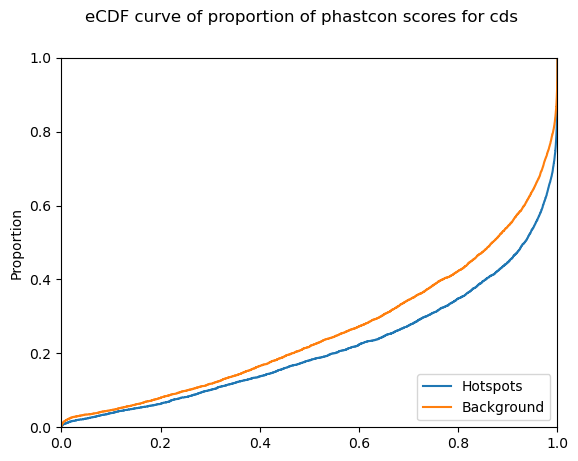

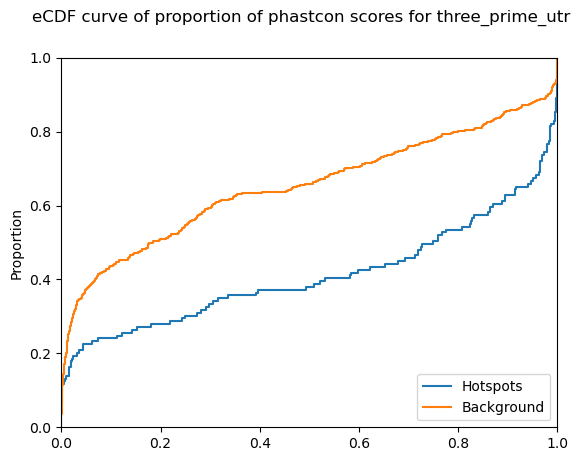

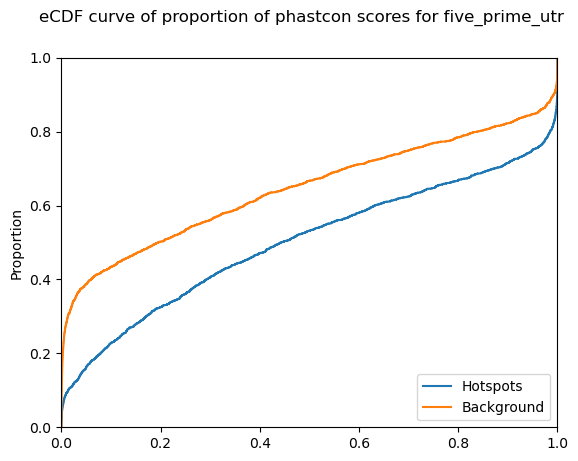

In [35]:
for region in ['cds', 'three_prime_utr', 'five_prime_utr']:
    fig, ax = plt.subplots()
    i = 0
    for a, label in zip([hotspot_phastcons[region], background_phastcons[region]], ['Hotspots', 'Background']):
        sns.ecdfplot(a, ax=ax, color=colors[i], label=label)
        i += 1
    ax.set_xlim([0, 1])
    plt.legend(loc='lower right') # , bbox_to_anchor=(0, 1))
    fig.suptitle(f"eCDF curve of proportion of phastcon scores for {region}")
    fig.savefig(os.path.join(output_dir, f'phastcon_scores_ecdf_{region}.png'))

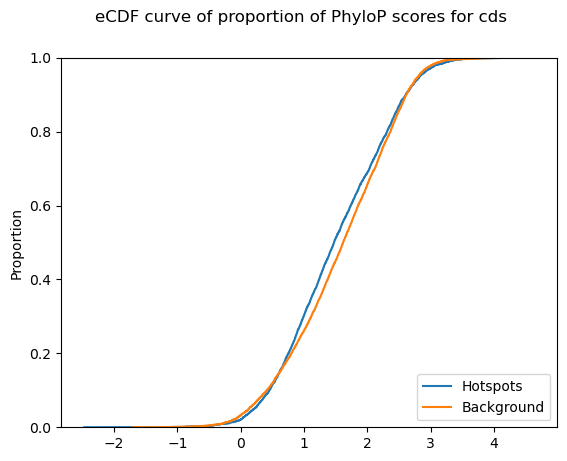

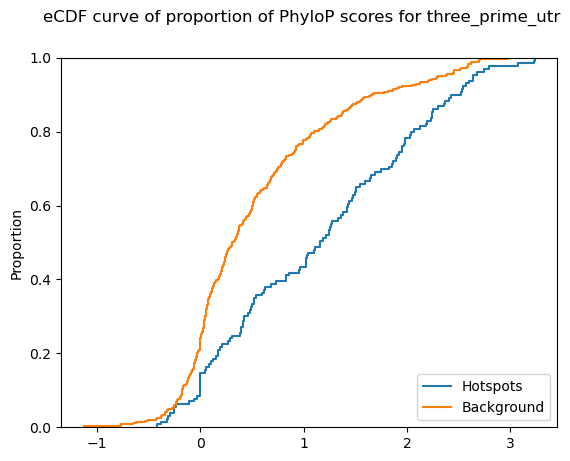

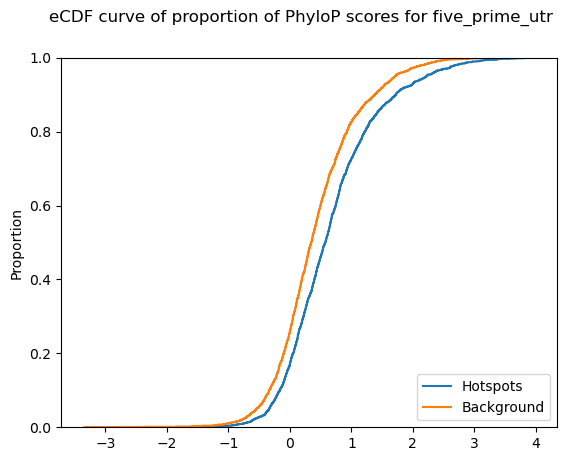

In [36]:
for region in ['cds', 'three_prime_utr', 'five_prime_utr']:
    fig, ax = plt.subplots()
    i = 0
    for a, label in zip([hotspot_phylop[region], background_phylop[region]], ['Hotspots', 'Background']):
        sns.ecdfplot(a, ax=ax, color=colors[i], label=label)
        i += 1
    plt.legend(loc='lower right') # , bbox_to_anchor=(0, 1))
    fig.suptitle(f"eCDF curve of proportion of PhyloP scores for {region}")
    fig.savefig(os.path.join(output_dir, f'phylop_scores_ecdf_{region}.png'))

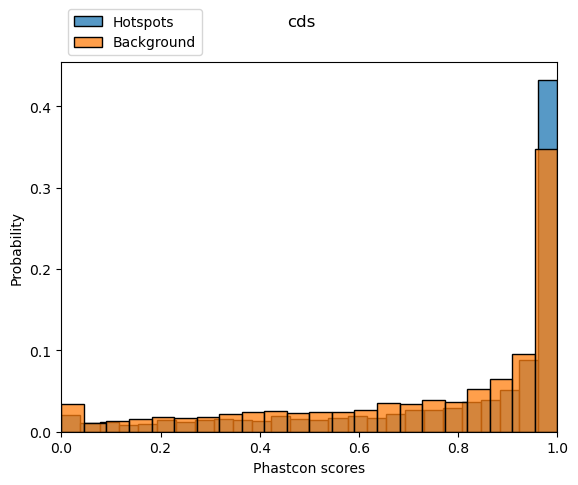

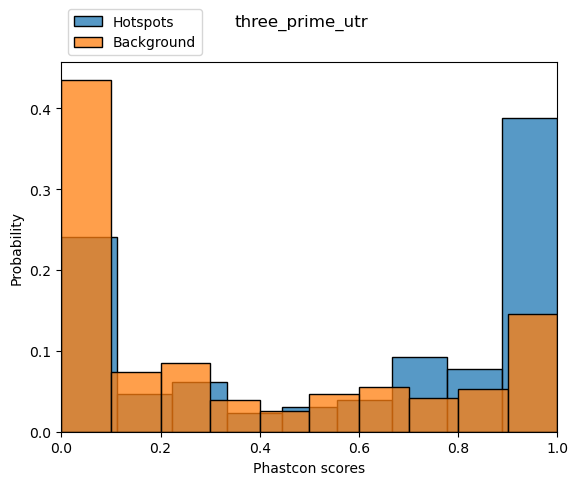

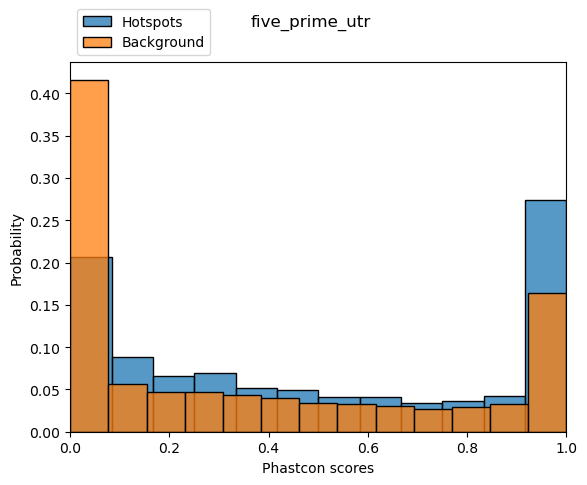

In [37]:
for region in ['cds', 'three_prime_utr', 'five_prime_utr']:
    fig, ax = plt.subplots()
    i = 0
    for a, label in zip([hotspot_phastcons[region], background_phastcons[region]], ['Hotspots', 'Background']):
        sns.histplot(a, ax=ax, color=colors[i], label=label, stat="probability")
        i += 1
    ax.set_xlim([0, 1])
    ax.set_xlabel("Phastcon scores")
    plt.legend(loc='lower left', bbox_to_anchor=(0, 1))
    fig.suptitle(f"{region}")
    # fig.savefig(os.path.join(output_dir, f'phastcon_scores_distribution_{region}.png'))
    fig.savefig(os.path.join(output_dir, f'phastcon_scores_distribution_{region}.svg'))

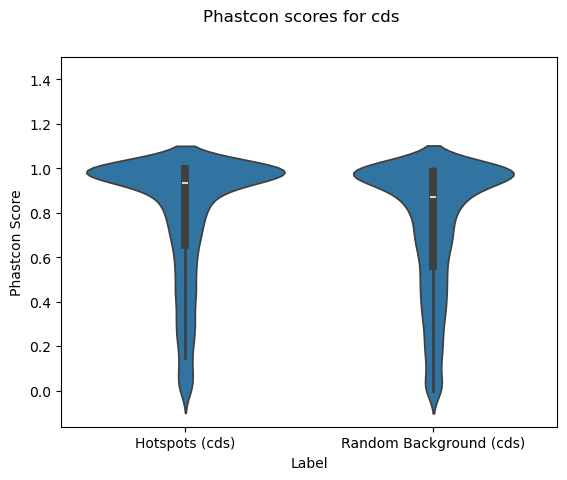

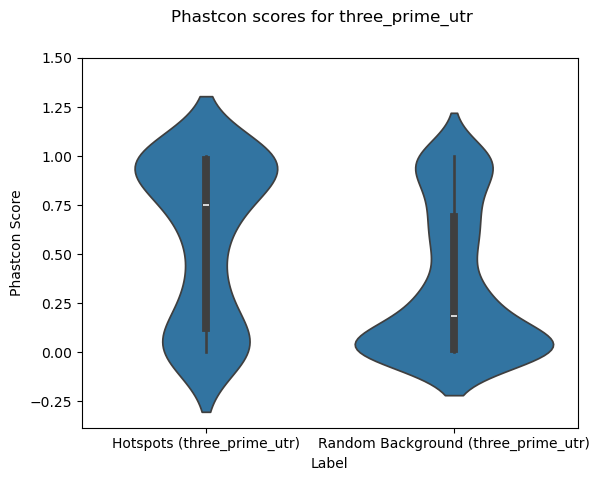

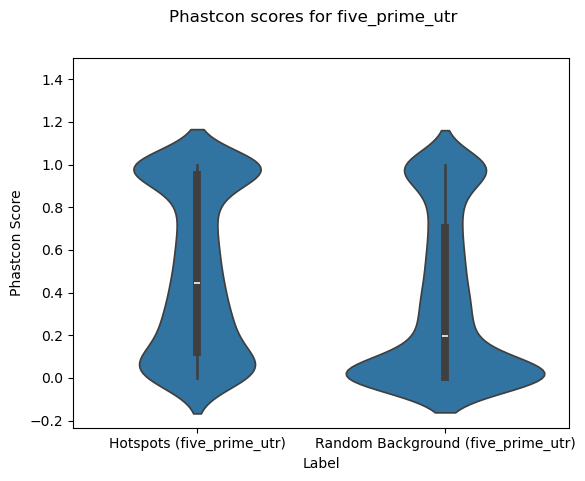

In [38]:
for region in ['cds', 'three_prime_utr', 'five_prime_utr']:

    hotspots_df = pd.DataFrame(hotspot_phastcons[region], columns=['Phastcon Score'])
    hotspots_df['Label'] = f'Hotspots ({region})'
    
    background_df = pd.DataFrame(background_phastcons[region], columns=['Phastcon Score'])
    background_df['Label'] = f'Random Background ({region})'
    
    df = pd.concat([hotspots_df, background_df])
    fig, ax = plt.subplots()
    ax = sns.violinplot(x="Label", y="Phastcon Score", data=df)
    ax.set_ylim(top=1.5)
    fig.suptitle(f"Phastcon scores for {region}")
    fig.savefig(os.path.join(output_dir, f'phastcon_scores_violin_{region}.svg'))